In [1]:
import sys
import torch
import torchvision

import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn import manifold
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

sys.path.append("../lib")

from swae.nn import AE
from swae.utils_plot import *
from utils_vmf import rand_von_mises_fisher
from swae.fid_score import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

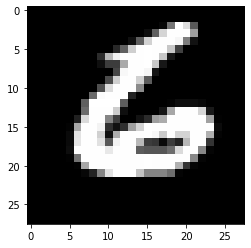

In [4]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = data[:,0]
    cpt += 32

plt.imshow(real_cpu[-1],"gray")
plt.show()

In [5]:
def val_mnist_ae(autoencoder, device, prior="unif_sphere", d=3):
    with torch.no_grad():
        autoencoder.eval()

        torch.manual_seed(42)
        r,c = 5,5
        if prior=="unif_sphere":
            z_random = torch.randn(r,c,d,device=device)
            z_random = F.normalize(z_random, p=2, dim=-1)
        elif prior == "vmf":
            mu = torch.tensor([1,0,0], dtype=torch.float64)
            kappa = 10
            X = rand_von_mises_fisher(mu, kappa=kappa, N=r*c)
            z_random = torch.tensor(X, device=device, dtype=torch.float)
        elif prior=="mixture_vmf":
            ps = np.ones(6)/6
            mus = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[-1,0,0],[0,-1,0],[0,0,-1]], dtype=torch.float64)
            mus = F.normalize(mus, p=2, dim=-1)
            Z = np.random.multinomial(r*c,ps)
            X = []
            for k in range(len(Z)):
                if Z[k]>0:
                    vmf = rand_von_mises_fisher(mus[k], kappa=10, N=int(Z[k]))
                    X += list(vmf)
            z_random = torch.tensor(X, device=device, dtype=torch.float)

        gen_imgs = autoencoder.decoder(z_random).detach().cpu().reshape(-1,28,28)

        cpt = 0
        fig,ax = plt.subplots(r,c)
        for i in range(r):
            for j in range(c):
                ax[i,j].imshow(gen_imgs[cpt],"gray")
                ax[i,j].axis("off")
                cpt += 1
                
        fig.set_size_inches(6, 6)
        plt.tight_layout()
        plt.show()

In [6]:
def plot_latent_sphere2(model, test_loader, device, name, axis=False):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        # yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())
            
    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    
    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets
    
#     fig = plt.figure(figsize=(4,3))
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    plot_3d_scatter(z, ax, colour=10*Y)

#     plt.scatter(z[:,0], -z[:,1], c=10*Y, cmap=plt.cm.Spectral)
    if not axis:
        plt.axis("off")
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.savefig("./"+name+".pdf", format="pdf", bbox_inches="tight")

    plt.show()

In [7]:
def plot_tsne(model, test_loader, device):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        # yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())

    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()

    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets

    tsne = manifold.TSNE(n_components=2, init="pca", random_state=0)
    X_2d = tsne.fit_transform(z)

    fig = plt.figure(figsize=(10,10))

    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=10*Y, cmap=plt.cm.Spectral)
    plt.show()

In [8]:
def euclidean_to_spherical(euc_coords):
    """
        https://github.com/katalinic/sdflows/blob/0f319d8ae6e2c858061a0a31880d4b70f69b6a64/utils.py#L4
    """
    if euc_coords.ndim == 1:
        euc_coords = np.expand_dims(euc_coords, 0)
    x, y, z = np.split(euc_coords, 3, 1)
    return np.concatenate((
        np.pi + np.arctan2(-y, -x),
        np.arccos(z)
    ), 1)


def scatter_mollweide(model, test_loader, device):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        # yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())

    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    
    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets

    spherical_coords = euclidean_to_spherical(z)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='mollweide')
    ax.scatter(spherical_coords[:,0]-np.pi, spherical_coords[:,1]-np.pi/2, c=10*Y, cmap=plt.cm.Spectral)
    
    ax.set_axis_off()
    plt.show()

### SSWAE Unif S2

In [9]:
model = AE(16, 3, normalize_output=True).to(device)

In [10]:
model.load_state_dict(torch.load("./results/swae_sphere_unif_sphere_d_3.model"))
model = model.to(device)

In [11]:
z = torch.randn(10000, 3, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

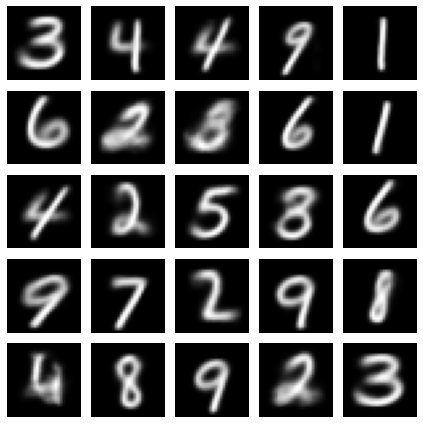

In [12]:
val_mnist_ae(model, device, d=3)

In [13]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'swae_sphere_unif_sphere_d_3.png',normalize=True)

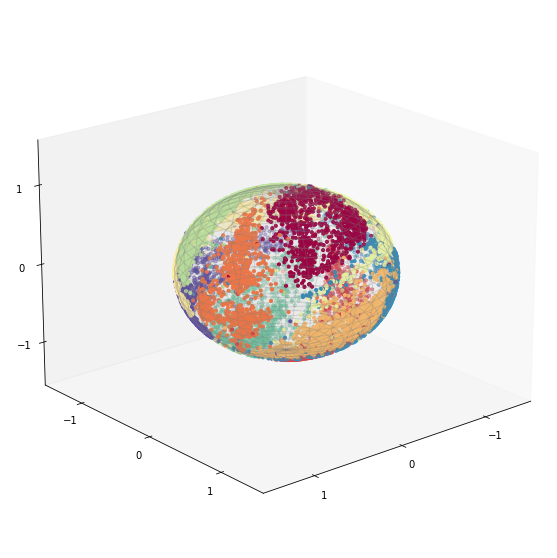

In [14]:
plot_latent_sphere(model, test_loader, device)

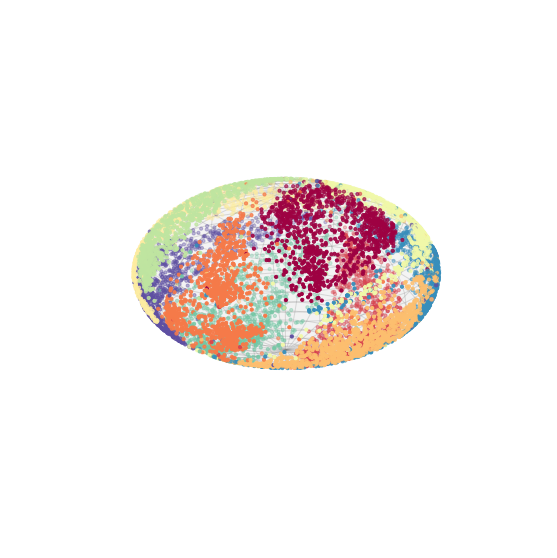

In [15]:
plot_latent_sphere2(model, test_loader, device, name="latent_swae_sphere_unif_sphere_d_3")

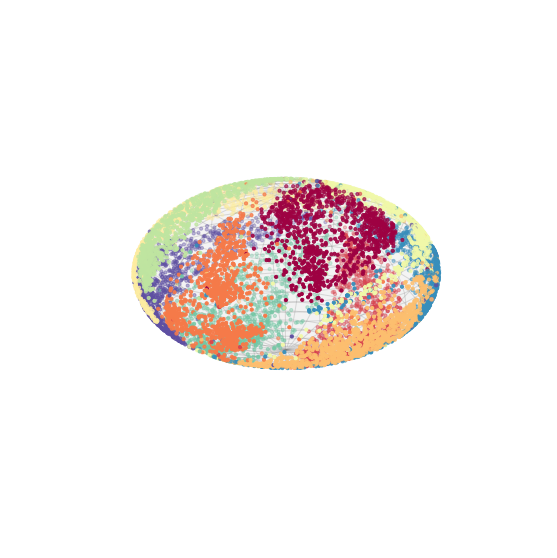

In [16]:
plot_latent_sphere2(model, test_loader, device, name="latent_swae_sphere_unif_sphere_d_3", axis=False)

~/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
~/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


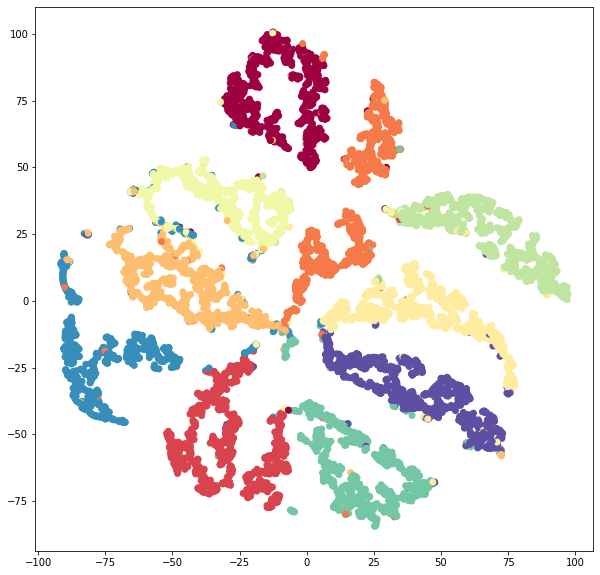

In [17]:
plot_tsne(model, test_loader, device)

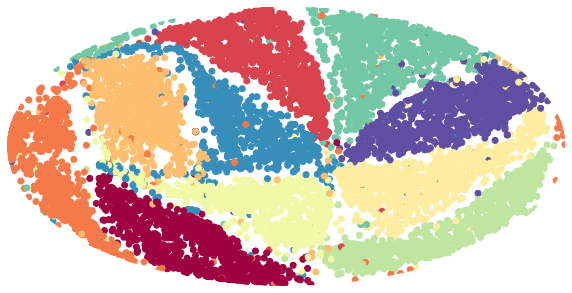

In [18]:
scatter_mollweide(model, test_loader, device)

In [19]:
L = []
for k in range(10):
    z = torch.randn(10000, 3, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)

In [20]:
print(np.mean(L), np.std(L))

69.58420141131053 0.18529136185029355


### SSWAE Unif S10

In [21]:
model = AE(16, 11, normalize_output=True).to(device)

model.load_state_dict(torch.load("./results/swae_sphere_unif_unif_sphere_d_11_0.model"))
model = model.to(device)

In [22]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

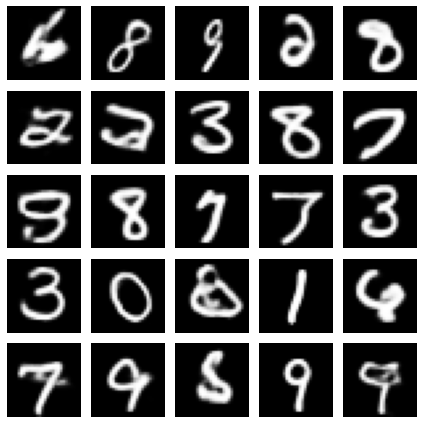

In [23]:
val_mnist_ae(model, device, d=11)

In [24]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'swae_sphere_unif_sphere_d_11.png',normalize=True)

In [25]:
L = []
for k in range(10):
    z = torch.randn(10000, 11, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

14.761101805937093 0.11924732964811664


In [29]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)

L = []
for k in range(5):
    print(k)
    model = AE(16, 11, normalize_output=True).to(device)

    model.load_state_dict(torch.load("./results/swae_sphere_unif_unif_sphere_d_11_" + str(k) + ".model"))
    model = model.to(device)
    
    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    print(k, L[-1])

0
9 14.7071196519083
1
9 14.799407478224992
2
9 14.875995216968192
3
9 14.63352198543572
4
9 15.519693342337916


In [30]:
print(np.mean(L), np.std(L))

14.907147534975024 0.3170718682659807


In [31]:
L

[14.7071196519083,
 14.799407478224992,
 14.875995216968192,
 14.63352198543572,
 15.519693342337916]

### WAE MMD RBF Unif S10

In [9]:
model = AE(16, 11, normalize_output=True).to(device)

model.load_state_dict(torch.load("./results/wae_mmd_rbf_unif_sphere_d_11_0.model"))
model = model.to(device)

In [10]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

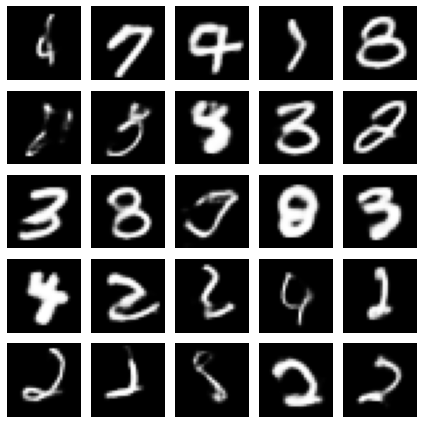

In [11]:
val_mnist_ae(model, device, d=11)

In [12]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'wae_mmd_rbf_unif_sphere_d_11.png',normalize=True)

In [14]:
L = []
for k in range(10):
    z = torch.randn(10000, 11, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

21.796069551501382 0.16523021298616142


In [15]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)

L = []
for k in range(5):
    print(k)
    model = AE(16, 11, normalize_output=True).to(device)

    model.load_state_dict(torch.load("./results/wae_mmd_rbf_unif_sphere_d_11_" + str(k) + ".model"))
    model = model.to(device)
    
    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    print(k, L[-1])

0
9 21.935830549746754
1
9 18.509276556250597
2
9 20.463714355709186
3
9 21.163215827735513
4
9 18.397834151860167


In [16]:
print(np.mean(L), np.std(L))

20.093974288260444 1.4184906019665724


In [17]:
L

[21.935830549746754,
 18.509276556250597,
 20.463714355709186,
 21.163215827735513,
 18.397834151860167]

### SAE Unif S10

In [18]:
model = AE(16, 11, normalize_output=True).to(device)

model.load_state_dict(torch.load("./results/sae_unif_sphere_d_11_0.model"))
model = model.to(device)

In [19]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

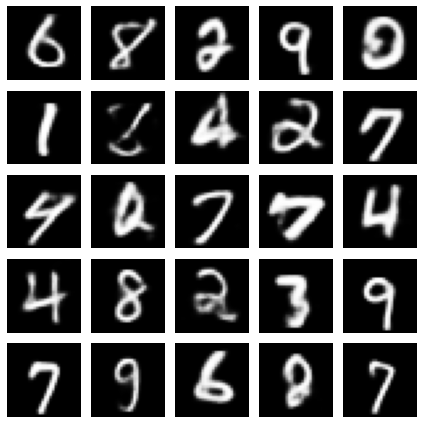

In [20]:
val_mnist_ae(model, device, d=11)

In [21]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'sae_unif_sphere_d_11.png',normalize=True)

In [22]:
L = []
for k in range(10):
    z = torch.randn(10000, 11, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

18.836059669741193 0.19037702540070642


In [23]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)

L = []
for k in range(5):
    print(k)
    model = AE(16, 11, normalize_output=True).to(device)

    model.load_state_dict(torch.load("./results/sae_unif_sphere_d_11_" + str(k) + ".model"))
    model = model.to(device)
    
    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    print(k, L[-1])

0
9 18.839454862469893
1
9 19.954257052886817
2
9 18.849639014539775
3
9 20.170732067669206
4
9 19.120966853895084


In [24]:
print(np.mean(L), np.std(L))

19.387009970292155 0.5648632858665856


In [25]:
L

[18.839454862469893,
 19.954257052886817,
 18.849639014539775,
 20.170732067669206,
 19.120966853895084]

### SWAE Unif S10

In [26]:
model = AE(16, 11, normalize_output=True).to(device)

model.load_state_dict(torch.load("./results/swae_unif_sphere_d_11_0.model"))
model = model.to(device)

In [27]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

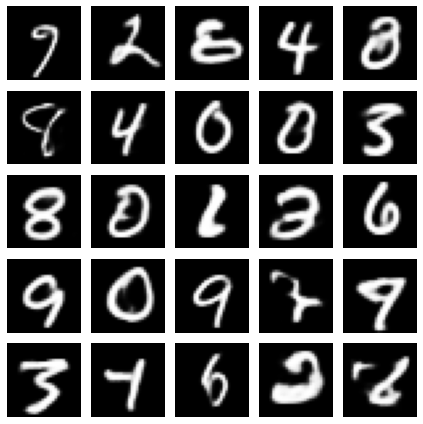

In [28]:
val_mnist_ae(model, device, d=11)

In [29]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'swae_unif_sphere_d_11.png',normalize=True)

In [30]:
L = []
for k in range(10):
    z = torch.randn(10000, 11, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

15.337833032766108 0.12909143099280923


In [31]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)

L = []
for k in range(5):
    print(k)
    model = AE(16, 11, normalize_output=True).to(device)

    model.load_state_dict(torch.load("./results/swae_unif_sphere_d_11_" + str(k) + ".model"))
    model = model.to(device)
    
    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    print(k, L[-1])

0
9 15.16561118287379
1
9 15.1718909422041
2
9 14.891473904386714
3
9 15.779898912506695
4
9 14.888999469087992


In [32]:
print(np.mean(L), np.std(L))

15.179574882211858 0.32498591148497286


In [33]:
L

[15.16561118287379,
 15.1718909422041,
 14.891473904386714,
 15.779898912506695,
 14.888999469087992]

### WAE MMD IMQ Unif S10

In [9]:
model = AE(16, 11, normalize_output=True).to(device)

model.load_state_dict(torch.load("./results/wae_mmd_imq_unif_sphere_d_11_0.model"))
model = model.to(device)

In [10]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

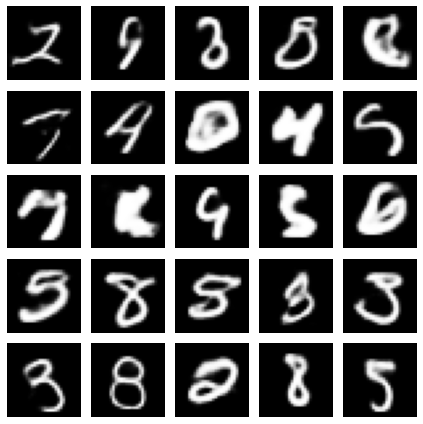

In [11]:
val_mnist_ae(model, device, d=11)

In [12]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'wae_mmd_imq_unif_sphere_d_11.png',normalize=True)

In [13]:
L = []
for k in range(10):
    z = torch.randn(10000, 11, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

19.02111895716266 0.17231426148205853


In [14]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)

L = []
for k in range(5):
    print(k)
    model = AE(16, 11, normalize_output=True).to(device)

    model.load_state_dict(torch.load("./results/wae_mmd_imq_unif_sphere_d_11_" + str(k) + ".model"))
    model = model.to(device)
    
    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    print(k, L[-1])

0
9 19.17727703180782
1
9 17.28114600441964
2
9 18.187592818956915
3
9 17.82341682804949
4
9 18.12680943489221


In [15]:
print(np.mean(L), np.std(L))

18.119248423625216 0.6187220149657795


In [16]:
L

[19.17727703180782,
 17.28114600441964,
 18.187592818956915,
 17.82341682804949,
 18.12680943489221]

### Circular GSWAE Unif S10

In [9]:
model = AE(16, 11, normalize_output=True).to(device)

model.load_state_dict(torch.load("./results/gswae_circular_unif_sphere_d_11_0.model"))
model = model.to(device)

In [10]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)
# gen_imgs = model.decoder(z).detach().cpu()

gen_imgs = torch.zeros((10000,28,28))
for k in range(10):
#     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
    gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)

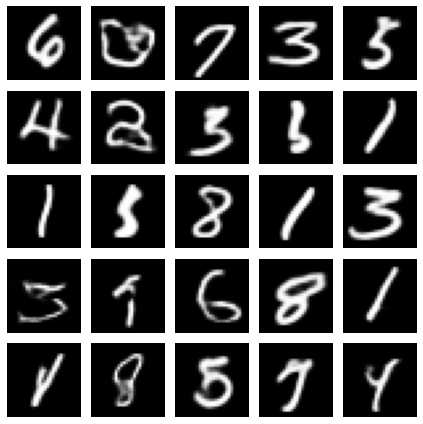

In [11]:
val_mnist_ae(model, device, d=11)

In [12]:
vutils.save_image(gen_imgs[:64].reshape(-1,1,28,28),'gswae_circular_unif_sphere_d_11.png',normalize=True)

In [13]:
L = []
for k in range(10):
    z = torch.randn(10000, 11, device=device)
    z = F.normalize(z, p=2, dim=-1)
    # gen_imgs = model.decoder(z).detach().cpu()

    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

14.361399726354147 0.17604342533692785


In [14]:
z = torch.randn(10000, 11, device=device)
z = F.normalize(z, p=2, dim=-1)

L = []
for k in range(5):
    print(k)
    model = AE(16, 11, normalize_output=True).to(device)

    model.load_state_dict(torch.load("./results/gswae_circular_unif_sphere_d_11_" + str(k) + ".model"))
    model = model.to(device)
    
    gen_imgs = torch.zeros((10000,28,28))
    for k in range(10):
    #     print(model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().shape)
        gen_imgs[1000*k:1000*(k+1)] = model.decoder(z[1000*k:1000*(k+1)]).detach().cpu().reshape(-1,28,28)
    
    
    fid = evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    print(k, L[-1])

0
9 14.59587787669355
1
9 15.393670670370454
2
9 14.969272089119642
3
9 14.938630481946774
4
9 15.157931132457634


In [15]:
print(np.mean(L), np.std(L))

15.01107645011761 0.26356422874589963


In [16]:
L

[14.59587787669355,
 15.393670670370454,
 14.969272089119642,
 14.938630481946774,
 15.157931132457634]